# Testing degradation on ABC vs true distribution

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))

for bandwidth in [0.1, 0.3, 1.0]:
    ax.plot(x_grid, kde_sklearn(x, x_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.5)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, normed=True)
ax.set_xlim(-4.5, 3.5)
ax.legend(loc='upper left')

NameError: name 'ax' is not defined

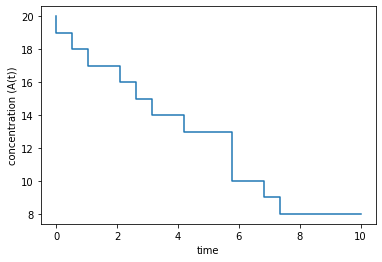

In [2]:
np.random.seed(2)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 20)

values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0], [0.3])

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

In [3]:
np.random.seed(0)

from math import comb

n_0 = 20

# Probability for one data point
def compute_prob(n, t, k):
    exp_term = np.exp(-k * n * t)
    comb_term = comb(n_0, int(n)) 
    t_term = (1 - np.exp(-k * t)) 
    return exp_term * comb_term * (t_term ** (n_0 - n))

# Probability for multiple data points
def prob_gen(data, times, k):
    all_prob = 1.0
    for i in range(len(data)):
        computed_prob = compute_prob(data[i][0], times[i], k)
        all_prob *= computed_prob
    return all_prob


# Compute integral
from scipy import integrate

func = lambda x : prob_gen(values, times, x)
int_val = integrate.quad(func, 0.01, 0.3)
print("likelihood integrate value="+str(int_val[0]))

# True posterior
def posterior(data, times, k):
    return prob_gen(data, times, k) / int_val[0]

thetas = np.linspace(0.01, 0.3, 200)
true_prob = []
for i in range(len(thetas)):
    true_prob.append(posterior(values, times, thetas[i]))

v_func = lambda x : posterior(values, times, x)
i_val = integrate.quad(v_func, 0.01, 0.3)

print("posterior integrate value="+str(i_val[0]))

likelihood integrate value=5.086995413811021e-16
posterior integrate value=0.9999392938746746


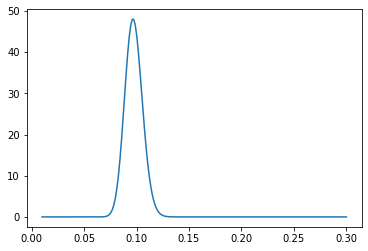

In [4]:
plt.plot(thetas, true_prob)
plt.show()

# Rejection ABC

In [29]:
np.random.seed(0)

abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(0.7)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     1046   0.000956022945   0:00.5
2     1397   0.00143163923    0:00.7
3     2614   0.00114766641    0:01.3
20    19895  0.00100527771    0:08.1
40    42877  0.000932901089   0:16.7
60    73388  0.000817572355   0:29.1
80    97241  0.000822698245   0:38.4
100   110681  0.000903497439   0:43.4
120   132558  0.000905264111   0:51.6
140   158391  0.000883888605   1:01.9
160   178814  0.000894784525   1:10.5
180   211164  0.000852418026   1:22.5
200   237387  0.000842506119   1:32.1
220   262436  0.000838299624   1:42.1
240   285525  0.000840556869   1:50.6
260   321198  0.000809469548   2:03.8
280   348160  0.000804227941   2:14.0
300   379124  0.000791297834   2:25.5
320   406451  0.000787302775   2:36.1
340   430202  0.000790326405   2:45.7
360   461336  0.00078034231    2:58.6
380   491470  0.000773190632   3:10.3
400   507176  0.000788680852   3:17.6
420   535997  0.000783586475   3:29.5

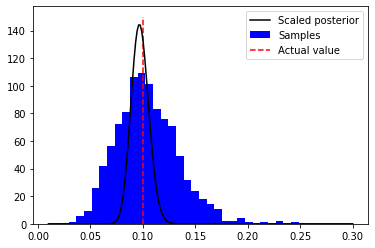

In [34]:
plt.hist(samples[:,0], 30, color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=150, label="Actual value", color="red")
mod_true_prob = [x * 3 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

# Compute Kernel Density Estimate

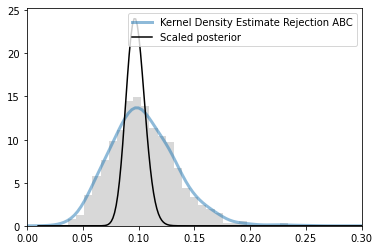

In [65]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)

t_samples = np.array([x for y in samples[:, 0] for x in y])

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

# Save samples 

In [67]:
rej_abc_samples = samples

transf_samples = [x for y in samples[:, 0] for x in y]

print(transf_samples)

[0.08236422720534019, 0.10178792705852524, 0.14862222267015268, 0.12535874076487727, 0.1282667539522229, 0.12802938185552537, 0.13280479677759602, 0.11135752309729809, 0.10874753703947798, 0.1119494050662071, 0.12563008402922524, 0.13858492244511628, 0.09297479658263343, 0.11346175679890907, 0.09771545632863245, 0.08172476315317154, 0.0760038592284387, 0.10628029661612688, 0.09548408470473979, 0.1241595643723361, 0.05777665626257608, 0.057069730312707845, 0.10801465983137083, 0.07185434377957661, 0.14219572454720705, 0.06453438990325407, 0.09607347618995866, 0.09178225854971883, 0.16943272197104692, 0.12556987097215572, 0.09660067494396307, 0.10107166783413322, 0.08277157540697834, 0.10896963627515248, 0.09723980927858196, 0.05943635205539226, 0.12893912234451457, 0.1577562316587515, 0.08960639524698527, 0.06834083054931442, 0.07228280338227472, 0.17251222589222723, 0.12258000898510661, 0.08729846484075159, 0.09671612546686371, 0.07352804152034058, 0.11698606066076506, 0.08535337715252

In [91]:
some_str = "0.08236422720534019, 0.10178792705852524, 0.14862222267015268, 0.12535874076487727, 0.1282667539522229, 0.12802938185552537, 0.13280479677759602, 0.11135752309729809, 0.10874753703947798, 0.1119494050662071, 0.12563008402922524, 0.13858492244511628, 0.09297479658263343, 0.11346175679890907, 0.09771545632863245, 0.08172476315317154, 0.0760038592284387, 0.10628029661612688, 0.09548408470473979, 0.1241595643723361, 0.05777665626257608, 0.057069730312707845, 0.10801465983137083, 0.07185434377957661, 0.14219572454720705, 0.06453438990325407, 0.09607347618995866, 0.09178225854971883, 0.16943272197104692, 0.12556987097215572, 0.09660067494396307, 0.10107166783413322, 0.08277157540697834, 0.10896963627515248, 0.09723980927858196, 0.05943635205539226, 0.12893912234451457, 0.1577562316587515, 0.08960639524698527, 0.06834083054931442, 0.07228280338227472, 0.17251222589222723, 0.12258000898510661, 0.08729846484075159, 0.09671612546686371, 0.07352804152034058, 0.11698606066076506, 0.08535337715252439, 0.12248400516241725, 0.10268015045597216, 0.21867716898016654, 0.0885236425212834, 0.10748465814981485, 0.0819118784182684, 0.07082585500136976, 0.1689302242365553, 0.0908338863393618, 0.09275300247673728, 0.12574444024638556, 0.09693625246477211, 0.11072360066006783, 0.12204634891587055, 0.0823988137123594, 0.06578881690274471, 0.07172754788723529, 0.051155709454393426, 0.09791393249334764, 0.07663405732050756, 0.14991490651451625, 0.08882390039517792, 0.1176975061726003, 0.12310433852123592, 0.15474660210391314, 0.10088606525635115, 0.10156357567850692, 0.09873384294649264, 0.1543696152930693, 0.1511985571723616, 0.08706659908078289, 0.14114320225839036, 0.08028287195374124, 0.11602618763316955, 0.07838567269814635, 0.11770532320890825, 0.0631143294863175, 0.1287306800392842, 0.12425230379209112, 0.12392123023918633, 0.09246341617588355, 0.08665113163099586, 0.05302751963431441, 0.09490160048815022, 0.08374597542835761, 0.10392851977139642, 0.14266900764738816, 0.07912283049617212, 0.12253739550597094, 0.12266202904097451, 0.07312568011753143, 0.08439275345326179, 0.0770563883857275, 0.10813760974433897, 0.12723437852910816, 0.09092963185017848, 0.10760299624828189, 0.08747735964544899, 0.0875847297099095, 0.16109728225466038, 0.1154644071041236, 0.08576051325935816, 0.0874970239529757, 0.11003734885193742, 0.10521851610249562, 0.12572329558976292, 0.09520540191043557, 0.10164088917421785, 0.13286730514279277, 0.09089743584702646, 0.11657272497702684, 0.10732691710100158, 0.10338323511907667, 0.14381515949656584, 0.08980682208908182, 0.0937976739785164, 0.10657984507844404, 0.05034961903052678, 0.11246683278672645, 0.11463020811405988, 0.08641976424847317, 0.11959041597642975, 0.08392003100079765, 0.11723329240413449, 0.12355004568855209, 0.1566676316503259, 0.12886829189723573, 0.08519760153479224, 0.09522598142958097, 0.0963634878107327, 0.1778027579097255, 0.14490187482340336, 0.12131138077786713, 0.1159421242869928, 0.08795378142940674, 0.049955016253706276, 0.1179412330885895, 0.11239378451747724, 0.08556410432295826, 0.08836672492274267, 0.09539674930191856, 0.08360725353798844, 0.0727615200951941, 0.11055243887804819, 0.08947366344440237, 0.12206004239075481, 0.11224883748217991, 0.12330019044113233, 0.1255901280597711, 0.05922463132569961, 0.13321836887162944, 0.1471256848561897, 0.11794088897358818, 0.09955926638355757, 0.0982209214050136, 0.07428949463588186, 0.14347486275992793, 0.06259859608606623, 0.05709663939698427, 0.08202650585561735, 0.10816349829458106, 0.1670867728637714, 0.09998746139436963, 0.0691853154778957, 0.09502759755652367, 0.10974208765162917, 0.1044146891004698, 0.1454988881057013, 0.10177586741040778, 0.1183093834999201, 0.10856202267241533, 0.08628099249143349, 0.09225128648556315, 0.11733800991271875, 0.12704333475946272, 0.11521574088218722, 0.06295243613467379, 0.09915876381278371, 0.09788560469314933, 0.11271453970897898, 0.146460483075516, 0.08851730950273164, 0.10567002301662669, 0.1152063025344476, 0.0652553625343643, 0.07862347953784522, 0.0954436285645541, 0.09543790599865505, 0.09058722372444866, 0.09653685486564124, 0.08004134607579004, 0.22957823616206485, 0.06885094199265686, 0.10390535807977348, 0.08391906724612068, 0.15514834668115926, 0.1313947204446784, 0.09951439514531359, 0.13136985253190284, 0.12352774234127045, 0.07741689845826662, 0.07137717589910753, 0.13026943880015052, 0.07356765208630335, 0.1575198955847833, 0.08021242471209357, 0.10673421086111526, 0.08521395808725513, 0.055399329178514596, 0.150386809377164, 0.061778194373484016, 0.1078828849862508, 0.1341762947263137, 0.0997295002319806, 0.10171838080993802, 0.06367257757708845, 0.08760224782759973, 0.15641274803723298, 0.12447375418547046, 0.08633640109193728, 0.11487111824069954, 0.0756282936767957, 0.05777660887204558, 0.10118008879219194, 0.096501364067772, 0.03960552873227746, 0.09618372638157287, 0.11087092700295693, 0.07846972317072672, 0.11196009871550079, 0.11001201127692398, 0.10893188095719522, 0.09038792844918411, 0.07943462239780597, 0.060814001246487434, 0.11838856320368749, 0.06908004598048158, 0.0646739009923792, 0.12320435697568625, 0.07045170506895403, 0.0904663565633323, 0.0963394696498721, 0.05783614516314397, 0.09476348683680515, 0.07973884717371248, 0.08772003508652784, 0.10629640764608818, 0.13539832436739488, 0.09253955609706752, 0.0783923352621149, 0.12578118344039477, 0.06622781744924235, 0.07483139349681199, 0.12634071930321503, 0.13153538085051908, 0.0887388962370332, 0.07292809132930034, 0.13506284321885037, 0.0991518587598955, 0.1118617464412336, 0.084270649873356, 0.10838251771468418, 0.1326615898608404, 0.129896442291589, 0.14544364441963073, 0.07898126190607573, 0.12322429034504495, 0.11239323641512268, 0.16936740174236065, 0.0708631988571721, 0.2266874791767291, 0.07836758593033516, 0.19602115792792194, 0.06834464588956037, 0.05983408511464639, 0.13952614800548793, 0.13402480902058259, 0.09337474514515051, 0.09447214984258161, 0.09827768142630196, 0.09485814190269916, 0.13225472523631046, 0.10274678774453645, 0.11190304886884705, 0.11532023373816767, 0.1497550117069755, 0.04858756982708201, 0.11911019523906032, 0.09260558376630781, 0.09317612234701325, 0.10561377697303112, 0.16305279939734302, 0.09231848669587162, 0.10526794988762693, 0.08087473979201093, 0.057988020823470175, 0.09253964989780086, 0.06406351587098096, 0.06804773782189895, 0.10180226954393806, 0.10167375995241561, 0.15580136727863753, 0.06525500104450442, 0.1007344094894629, 0.10236374623710508, 0.09971139474194791, 0.09326051721220988, 0.13623554753266148, 0.10251517377425295, 0.1271703469939893, 0.12349285022035132, 0.10827318025035752, 0.029452402016039058, 0.10926580089340342, 0.08613402812489158, 0.12626672914636042, 0.09716951845296613, 0.07955388216801436, 0.10305592803903425, 0.10856289235129914, 0.1688014186216805, 0.09409483484395961, 0.15557918307621751, 0.08074367215820864, 0.07698021898524095, 0.09923623061197998, 0.10531125107617628, 0.1393739066503776, 0.08887523072697459, 0.10307609050571061, 0.09454620443086412, 0.08958932060432268, 0.1618115625403968, 0.11588461360359885, 0.10763940740669743, 0.1383839567726458, 0.09940820138965474, 0.12503980392343084, 0.0747961555684304, 0.13507740045376845, 0.08658866998949828, 0.12289274031672831, 0.13802433974589978, 0.08663787721688539, 0.12069287770363751, 0.0922733949878625, 0.08724345367543199, 0.06443796125618842, 0.12483953217592932, 0.07541094419145207, 0.11579442204194988, 0.1586059766773074, 0.13314153694669384, 0.09239649760991796, 0.09270656115042221, 0.0733568450425735, 0.09707810303103133, 0.12776087913312278, 0.06963837190150697, 0.13846370545060718, 0.09919735859653907, 0.16437667858804209, 0.06750278210257857, 0.07371797178161443, 0.0846723435265569, 0.11553701470867378, 0.1052259539307336, 0.09539983620132376, 0.13798912863806342, 0.09570495158848209, 0.17346009877322788, 0.13583389490704148, 0.11054391683468646, 0.10021565035088832, 0.10031476524841257, 0.14520920713129043, 0.1224526986894634, 0.04003712958490324, 0.24844919275213784, 0.12094869551143246, 0.08206401532235066, 0.14324595736289283, 0.0909317807354986, 0.10559515857519847, 0.08967104895896268, 0.11725052542303692, 0.08749037660315336, 0.07542441737200296, 0.10246399360440545, 0.14066155382183118, 0.06726153161957944, 0.048041739721747835, 0.11908223126265344, 0.1125278280836719, 0.07785486387374528, 0.0840152286839135, 0.09443477413775694, 0.08304092827656033, 0.1127486828750474, 0.056834026793559034, 0.0692929991894224, 0.0950082237936716, 0.10864539870918606, 0.11735250410143024, 0.1278867333020824, 0.09152262154207842, 0.14040342775438702, 0.056512218620746624, 0.04372661496387664, 0.05653958905822599, 0.1219492816519215, 0.09553305853773715, 0.10170761508556984, 0.12713005251292803, 0.11331966092843815, 0.10405829988003419, 0.15090850013335338, 0.10330079559137476, 0.16807684784272983, 0.1248389563568944, 0.11359575907491846, 0.07694383635800449, 0.08807960132936268, 0.11764752008213153, 0.08845443119252866, 0.17162914392367426, 0.07898809245652079, 0.08030686430176175, 0.10779739726037979, 0.11954994820852607, 0.12735586147603464, 0.15060728208284865, 0.1037162709912591, 0.12237851061070065, 0.07082828527260461, 0.12780049079182723, 0.10309809467788995, 0.1335538915630668, 0.11835271313417234, 0.1457590334433089, 0.06987869066895824, 0.12196292860081574, 0.04266806648734615, 0.07085124070954037, 0.08595207402326406, 0.06539553160255124, 0.1404163351960788, 0.13333994873171862, 0.1450649753636237, 0.1002093100243062, 0.1116947268362449, 0.15970998168610007, 0.08888636060451602, 0.11573483021353698, 0.15723101402240497, 0.12490324164515317, 0.06708594531091122, 0.0920091680865836, 0.06100170289135127, 0.10636292535112118, 0.12774728576214192, 0.17167267936530053, 0.08966454161033216, 0.13769667912060848, 0.09334201547751456, 0.14177974813408276, 0.10064686334261237, 0.11754505824110638, 0.09358392508205743, 0.0835142209310152, 0.11625934233136093, 0.09471729464590362, 0.1462473110963253, 0.10007402974006417, 0.132729951491552, 0.10773235624345068, 0.10111310305490302, 0.11855726756312263, 0.12572908848088168, 0.10944178314654998, 0.13055844074707915, 0.06556985960751051, 0.09154060796222657, 0.16485985846887027, 0.10859153142268325, 0.07874630797449693, 0.14336488610607726, 0.052611060962594776, 0.058153502068956184, 0.07082875881385113, 0.09227074895053582, 0.10244105615554236, 0.10927159805496978, 0.10591676817525507, 0.09393156339047759, 0.13329152718813322, 0.08023723129871814, 0.1035156180233834, 0.1151876314752977, 0.08502025285322728, 0.10523699369620253, 0.07002046571185559, 0.058485134412929636, 0.15902228913985597, 0.08913276560517941, 0.13609605726098722, 0.0923957374396762, 0.12317097622716205, 0.11152308420783476, 0.10643587767833294, 0.09863996962081299, 0.06136633511448633, 0.1416613965934542, 0.11513996580869891, 0.06673137474510843, 0.10447829545435722, 0.09727600535156554, 0.11903148210117213, 0.12884286990677252, 0.0550571874692127, 0.09843018104427192, 0.15378039171514327, 0.1312441052962853, 0.1031724566432675, 0.05751466643465838, 0.13173843655099535, 0.12263081029005667, 0.10610579612110557, 0.13292178876883454, 0.08926356829261685, 0.11995499988614185, 0.08987531886138318, 0.0928156438305613, 0.12511219567978057, 0.06930179077036455, 0.1132123809344977, 0.07873135529336216, 0.06729867313564669, 0.09443066697841482, 0.11730293206979299, 0.13329675484591808, 0.08317387938259906, 0.14866079550918535, 0.06136031296694106, 0.0750763877282941, 0.10259785109279644, 0.10863470834452678, 0.09527841300568947, 0.09865015697982313, 0.13169012232826183, 0.06091499738168179, 0.10383571221327138, 0.19604789433769554, 0.08508400879306502, 0.06493529047605288, 0.10110239154468517, 0.1058368799253428, 0.1852945889007194, 0.08080513101479433, 0.11806208908197646, 0.0918388291098663, 0.08694206658279018, 0.1028558317788828, 0.14806996539133205, 0.0792128183847691, 0.10567868932205124, 0.0782245255156048, 0.11043474657296024, 0.0794066466799105, 0.08901144641436111, 0.06046893321955505, 0.1312325287129844, 0.10322196361363072, 0.13078049201517206, 0.1112461082078711, 0.09314951070804821, 0.10075077834934097, 0.10214826687288632, 0.0684834471159821, 0.09061815123963221, 0.13222851664929702, 0.09739329895999521, 0.08253953864896682, 0.09310599832616158, 0.09468784669082193, 0.08050888568186888, 0.07377204344196443, 0.08507489765241888, 0.11007563899869242, 0.10324555128595607, 0.12442363032733246, 0.17017177823955346, 0.05597672287187173, 0.1291329380130737, 0.08536628853803963, 0.12534587568181588, 0.09598027526441218, 0.0742462513886233, 0.15573731137127758, 0.12330324011723631, 0.12901746928053584, 0.12307222077140817, 0.1035675300364349, 0.07256333323535173, 0.08480656123519467, 0.11120250833024811, 0.09251127918200971, 0.09379897207934176, 0.10684763402127091, 0.07223436319111831, 0.06587517031340019, 0.07922649278498932, 0.1106799205491442, 0.11082401573730527, 0.0704574509039381, 0.07937138997686169, 0.09124370584603927, 0.15911589024125114, 0.0674288217719957, 0.06193312986794279, 0.09957416130945675, 0.12417158897166425, 0.0669532945107397, 0.09553633375181522, 0.11486671613800681, 0.09324874410500768, 0.07460351295197999, 0.0965354548687033, 0.09364443256998543, 0.1528334736762891, 0.11494646152959637, 0.1242403967023966, 0.13909672862663003, 0.1443873321219951, 0.07668153506739768, 0.17207217892660065, 0.09211950035511747, 0.09911206859034985, 0.1267274420724743, 0.16507562971343054, 0.12211657048567127, 0.10306770038080744, 0.12301636530109175, 0.1171828504479754, 0.1337933308146199, 0.12095000158489191, 0.12331463468092069, 0.12708265402788202, 0.0929219573909122, 0.11691185647876645, 0.08502422702472394, 0.1535158986619995, 0.11228513238306177, 0.12400703992139667, 0.13360853673971912, 0.11912070452990375, 0.1164383390912046, 0.0980907168999255, 0.06653676937858881, 0.11161530667963006, 0.12055785196706692, 0.07435395819808753, 0.13595327752384498, 0.09425372192392184, 0.09226181081162861, 0.1058688331158893, 0.12631573850852001, 0.08819057758180893, 0.15250390757623544, 0.07988977810839254, 0.11260421959955612, 0.0816039255985578, 0.07275007901479519, 0.03939445213550462, 0.11113894965212567, 0.06074279515437013, 0.08154506271250596, 0.12021718395014414, 0.056303128208130555, 0.19286960314980342, 0.0880036028653663, 0.16753078528277054, 0.14890033226213495, 0.16505333614635198, 0.14703974448105497, 0.1159223740382131, 0.06528466753333101, 0.08787553493136079, 0.10484067612847182, 0.0751255515176528, 0.06141146045123794, 0.095604548957928, 0.09798257281642493, 0.16300586045496424, 0.13769302085301383, 0.07287947093591453, 0.1384858710546061, 0.10733230352318134, 0.06686928811679424, 0.12044886605100841, 0.08214571035190578, 0.10404643650473386, 0.1431603408415673, 0.1060059203004, 0.1328972426496124, 0.12691698419047512, 0.09153495750034414, 0.18321518774539952, 0.09760266356283033, 0.10541889183145371, 0.12886828780832013, 0.08286361819826817, 0.10262587732800933, 0.07250333123561846, 0.05488774274547515, 0.11379174340851383, 0.07572454789643383, 0.07949156725710853, 0.08630803702367913, 0.07809122888225205, 0.10043272288718222, 0.0918629896094194, 0.09657457230118612, 0.08693741382090464, 0.1179301188249089, 0.08770288789326089, 0.12827920598816364, 0.17583320249470583, 0.08976308054228693, 0.08590747420994861, 0.09577101566057968, 0.08663820044518838, 0.10145647062508156, 0.1266126093712312, 0.12589446135002053, 0.1032812417713439, 0.10393647515081668, 0.08926117941469643, 0.06774954803956981, 0.14878537978769202, 0.07158406195640557, 0.16049323737226348, 0.12967153615803426, 0.09007332449455248, 0.08985474717420373, 0.10706595634516726, 0.0840212693368455, 0.08289812265059669, 0.06554841193025097, 0.11532021479230603, 0.05693812206149542, 0.10100624399393546, 0.12344431944155486, 0.10173999411096499, 0.08230229599266216, 0.1423642184502572, 0.1424511715809716, 0.08773305396457205, 0.1083856764062385, 0.10883852878527016, 0.07849792773482546, 0.07415458156497409, 0.1408699989877575, 0.11550274002005048, 0.07640329503306441, 0.12999856924276673, 0.1980497828640591, 0.0710236991475153, 0.10808729248054348, 0.1031147483131883, 0.08664801152141852, 0.17079862516860464, 0.14960000326311232, 0.0976273284088995, 0.09900585330147986, 0.12553820422196185, 0.08930736419413977, 0.057939494464773464, 0.10014140334166684, 0.13941257823914738, 0.1346638955671213, 0.08158456262641892, 0.1304096750160096, 0.1080535679222974, 0.104838786048103, 0.08746772989724082, 0.09661255153031105, 0.08120646941050978, 0.14917667237273505, 0.13758649681768167, 0.11537724813296736, 0.0712764351273067, 0.08834425805044767, 0.14715230054057746, 0.10315195109078086, 0.11073097724216988, 0.0739592545399356, 0.09925110136500838, 0.09805985278328178, 0.06890161682970179, 0.11888690365779836, 0.14102698064748118, 0.10080758805979526, 0.07007419010143369, 0.08485681527595985, 0.15152930001728337, 0.08660479238649986, 0.12754388087130272, 0.1117709732547996, 0.11144124572041454, 0.05699051438661392, 0.04367478921876828, 0.07513355571397601, 0.06820775958745816, 0.06942251457692383, 0.11176132719368993, 0.07483126769265473, 0.10062861319020597, 0.11051047591038239, 0.1354641367275086, 0.10998782287896838, 0.08422184510286874, 0.07757973390911242, 0.10433514195284824, 0.06006094509203594, 0.05823971456878395, 0.08803804688759052, 0.14754948239333254, 0.109414653936614, 0.10458055896055408, 0.08935230310926785, 0.10058833773650196, 0.07052081869773459, 0.12217966442070041, 0.06446276340464731, 0.06305914219742641, 0.14348117007918768, 0.1086676822958629, 0.13880689302502533, 0.11997748564879496, 0.12211848355372042, 0.11158839073610859, 0.08293326646711568, 0.05663235942904956, 0.1130158571107189, 0.13162422720759417, 0.12399809155989422, 0.07320711259473511, 0.12286048517196835, 0.15575268121340394, 0.08890207619448423, 0.05971887516211002, 0.07888041599158688, 0.11773787332707565, 0.09597345593760484, 0.09319296374357042, 0.08042732626130839, 0.10996797103602111, 0.07177128654104505, 0.0917618961113958, 0.10980023035615971, 0.09917306250051489, 0.10662143550671671, 0.13251783989097754, 0.12699185459416132, 0.08402594315393526, 0.09388838415413141, 0.12256958587909365, 0.11194235669681689, 0.09179252281116682, 0.10039601239016786, 0.07532769026830385, 0.06637273326675068, 0.05016110212851053, 0.08115879449653816, 0.07842069881226714, 0.050719671501245546, 0.1320635636079378, 0.0835223846051049, 0.07909260684186505, 0.11366487717386826, 0.09314971169437165, 0.11413009669449292, 0.13847990558045728, 0.07588160233132586, 0.0985869472032563, 0.14422731166305783, 0.11179774677734682, 0.1382993785457274, 0.1110388144971992, 0.12929941178433957, 0.04462084218428223, 0.13092619893271523, 0.15231177322153094, 0.07806008185370268, 0.08952957281845736, 0.10107712226198996, 0.10779860604155837, 0.09823023090746193, 0.05562200377027947, 0.06022683307434368, 0.06942103687259943, 0.09517923010222361, 0.09444411632759976, 0.1257774426377582, 0.1033720390189326, 0.11789100385709365, 0.10157791587908868, 0.06280511971795495, 0.056841096804245594, 0.10544057741115699, 0.1242484837776903, 0.19289705664138593, 0.1370892094707351, 0.08380906622310615, 0.13814901532430413, 0.0919218024968213, 0.13391956961482052, 0.07482258401425106, 0.09882915769177666, 0.1041146015472992, 0.06433585497305773, 0.11680671814796668, 0.06104692073206816, 0.1428746481315446, 0.12934587193128527, 0.09633565380835087, 0.06472644932293523, 0.0750392052552757, 0.04915334172186324, 0.13121411685098214, 0.10207471472601275, 0.09471138993875698, 0.1529141255302898, 0.10587681853164027, 0.16501550075459478, 0.0770704662777632, 0.1036562765223918, 0.10988512702245254, 0.08658216294481108, 0.13126041732339244, 0.08897614126298374, 0.1356719944911485, 0.07876536558414711, 0.1289501209587775, 0.08832007339878055, 0.1137505897144997, 0.06141083600731767, 0.08476170126914928, 0.09306752518961026, 0.1166799776351033, 0.10334182116302985, 0.08332184519935538, 0.07364418216205199, 0.05902978427401971, 0.09451732267600967, 0.13156346361509413, 0.12861335115132846, 0.167920023756012, 0.10615362463258497, 0.11229937375328897, 0.10018014610130362, 0.11041691448758, 0.1015771674593164, 0.09860547825638652, 0.12598791276780155, 0.0938296474139507, 0.09788772561559474, 0.07632491114990538, 0.12319151863535616, 0.10405499283236654, 0.10803057876139543, 0.1318485653461174, 0.05940474810832999, 0.16528880786650138, 0.08329737957180518, 0.11212135589964836, 0.08410694060813098, 0.10694042816219827, 0.0999588372406954, 0.12522021190753144, 0.06934856999830849, 0.06707259327405024, 0.1237230815706179, 0.10161713963590961, 0.10670251452082403, 0.11282436907376386, 0.09811111562552167, 0.13299551334101326, 0.08829036860492605, 0.12441371376696433, 0.09811380839106133"

In [93]:
lmao = [ch for ch in some_str]

saved = list(filter(None, some_str.split(',')))

result = [float(s) for s in saved]

rej_abc_samples = result

# PMC Degradation (with smc)

In [86]:
np.random.seed(0)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([0.9, 0.8, 0.7]))

# produce intermediate distributions of size 1000
abc.sampler().set_intermediate_size(1000)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=0.8
Trying t=2, threshold=0.7
Iter. Eval. Acceptance rate Time m:s
1     276706  3.61394404e-06   6:38.6
2     277468  7.2080384e-06    6:40.2
3     277592  1.08072279e-05   6:40.4
20    285656  7.00142829e-05   6:54.8
40    302745  0.000132124395   7:19.5
60    318268  0.000188520366   7:30.9
80    332004  0.000240960952   7:40.1
100   341892  0.000292490026   7:46.8
120   352484  0.000340440985   7:53.9
140   366425  0.000382070001   8:15.9
160   375023  0.000426640499   8:30.6
180   387938  0.000463991669   8:55.7
200   407252  0.000491096422   9:32.0
220   418397  0.00052581639    9:50.5
240   426611  0.000562573398  10:05.1
260   439690  0.000591325707  10:28.8
280   454715  0.000615770318  10:57.0
300   466982  0.000642423048  11:19.8
320   477344  0.000670376081  11:39.3
340   487031  0.000698107513  11:57.1
360   496636  0.000724876972  12:15.0
380   510053  0.000745020616  12:40.7
400   522979  0.000764849067  13:

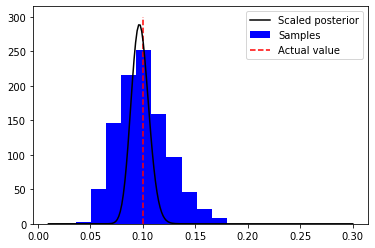

In [87]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=300, label="Actual value", color="red")
mod_true_prob = [x * 6 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

## Comput KDE

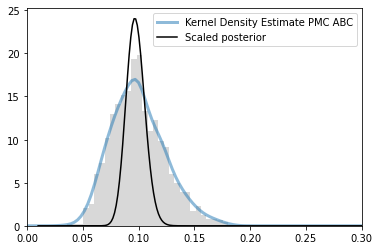

In [91]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)

t_samples = np.array([x for x in samples[:, 0]])

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.007),
            label='Kernel Density Estimate PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

## Save data

In [93]:
true_pmc_samples = samples[:, 0]
print(true_pmc_samples)

[0.13483937 0.06944909 0.13676759 0.15279609 0.08982677 0.16879974
 0.09951806 0.09412909 0.11833373 0.12037775 0.15355311 0.09046752
 0.08693453 0.10731102 0.13051183 0.08127951 0.15050703 0.08652541
 0.09296141 0.13979808 0.09486236 0.0971014  0.12133723 0.10604816
 0.08200857 0.13481587 0.15924984 0.08243267 0.15293088 0.12814093
 0.07466803 0.10486608 0.08529969 0.14193043 0.12815445 0.07848743
 0.07200675 0.09048088 0.0593402  0.12453459 0.11240901 0.07895269
 0.11384015 0.17131862 0.06698876 0.15453346 0.10298162 0.12748119
 0.09580494 0.0721323  0.08325862 0.1097412  0.12163716 0.15217437
 0.11498349 0.06714661 0.0940738  0.10019471 0.13895821 0.12559765
 0.089281   0.1087544  0.11184234 0.11674313 0.11315508 0.13766795
 0.11819898 0.1226559  0.15339671 0.07323743 0.0860173  0.10093055
 0.07578074 0.14308813 0.07550207 0.12115882 0.0856314  0.13724077
 0.16614089 0.11479523 0.10433545 0.06925748 0.09330803 0.08416244
 0.09000958 0.08659663 0.0775645  0.1217464  0.12429618 0.1003

In [85]:
some_str = "0.13483937 0.06944909 0.13676759 0.15279609 0.08982677 0.16879974 0.09951806 0.09412909 0.11833373 0.12037775 0.15355311 0.09046752 0.08693453 0.10731102 0.13051183 0.08127951 0.15050703 0.08652541 0.09296141 0.13979808 0.09486236 0.0971014  0.12133723 0.10604816 0.08200857 0.13481587 0.15924984 0.08243267 0.15293088 0.12814093 0.07466803 0.10486608 0.08529969 0.14193043 0.12815445 0.07848743 0.07200675 0.09048088 0.0593402  0.12453459 0.11240901 0.07895269 0.11384015 0.17131862 0.06698876 0.15453346 0.10298162 0.12748119 0.09580494 0.0721323  0.08325862 0.1097412  0.12163716 0.15217437 0.11498349 0.06714661 0.0940738  0.10019471 0.13895821 0.12559765 0.089281   0.1087544  0.11184234 0.11674313 0.11315508 0.13766795 0.11819898 0.1226559  0.15339671 0.07323743 0.0860173  0.10093055 0.07578074 0.14308813 0.07550207 0.12115882 0.0856314  0.13724077 0.16614089 0.11479523 0.10433545 0.06925748 0.09330803 0.08416244 0.09000958 0.08659663 0.0775645  0.1217464  0.12429618 0.10038116 0.07516278 0.09467877 0.10711761 0.09666019 0.07520048 0.15265423 0.12293912 0.0511769  0.06782056 0.10582382 0.06612353 0.09563294 0.07596817 0.12641932 0.06885179 0.07484093 0.11805506 0.12212147 0.05366076 0.10102859 0.07216539 0.07740219 0.1017814  0.11025867 0.10237346 0.11924714 0.0914224  0.0981545  0.06499378 0.10655583 0.11617688 0.0657995  0.11384632 0.07844739 0.11660394 0.08176615 0.10795712 0.08102354 0.10402021 0.05031734 0.12263547 0.11278921 0.09239142 0.0871075  0.09754636 0.12747058 0.10545076 0.06778195 0.10060291 0.08227069 0.1180373  0.12507038 0.10500029 0.09746663 0.08351391 0.10026322 0.06272846 0.12167262 0.1473193  0.10106477 0.08999075 0.11639681 0.05048172 0.0757284  0.09065014 0.11747518 0.08740685 0.10309973 0.08409164 0.11374391 0.14482069 0.13115093 0.16045909 0.12026016 0.12838696 0.12739227 0.13555937 0.09467859 0.12256553 0.12218297 0.13017351 0.12950394 0.11311945 0.09991259 0.16401068 0.09169295 0.10247956 0.07780598 0.09399357 0.09243275 0.07157691 0.10970383 0.09577957 0.12164104 0.11015027 0.099974 0.11251434 0.0443572  0.13148308 0.10243491 0.08330601 0.0768386 0.11005292 0.11415883 0.06679982 0.0952077  0.09457413 0.09001641 0.10270314 0.07885444 0.09324266 0.1040043  0.07977154 0.11841427 0.09393092 0.14205683 0.10290164 0.09781561 0.09241626 0.07680938 0.1003776  0.07309351 0.1156034  0.12372775 0.10927788 0.12649721 0.08338221 0.13696551 0.08182387 0.10003099 0.10129311 0.08679196 0.08156674 0.14562173 0.10909644 0.08764342 0.09329201 0.08778577 0.08604942 0.07314911 0.11353106 0.07829427 0.09752975 0.11156975 0.09014321 0.1149586  0.10596634 0.09702539 0.07839823 0.06130704 0.08644557 0.10559088 0.09687398 0.07238988 0.0776347  0.09268105 0.09012735 0.12157191 0.10437562 0.08207599 0.12501085 0.1229446 0.07394343 0.07746611 0.08083755 0.06450108 0.1579786  0.10911884 0.12648471 0.09904998 0.10620295 0.08609147 0.09131255 0.09130171 0.08968202 0.06863209 0.08126944 0.09865307 0.09751582 0.09887051 0.13561347 0.12193756 0.10794843 0.12092052 0.16195974 0.07727667 0.08965455 0.10187639 0.10292624 0.11596359 0.06690826 0.15103804 0.09789598 0.08904495 0.05489066 0.09972013 0.06969632 0.12847069 0.09620446 0.12771051 0.0864434  0.14054274 0.11896849 0.09698384 0.09377662 0.09027892 0.1130952  0.07497357 0.08872931 0.12043341 0.06439231 0.07780316 0.09821874 0.07887285 0.13958137 0.07046478 0.09498756 0.12201863 0.13435928 0.115635   0.08118171 0.07503337 0.06798326 0.05867529 0.05779482 0.10071019 0.11824661 0.12968419 0.11454414 0.05323203 0.10426657 0.08096706 0.12577155 0.11808173 0.09788275 0.10954856 0.09603443 0.0960635  0.06212821 0.0885003 0.07443468 0.05214052 0.1103487  0.14811139 0.06520598 0.07152229 0.07127079 0.10317662 0.11219852 0.10277088 0.08852326 0.09146821 0.14478057 0.1634483  0.08530106 0.11619557 0.12075534 0.09994057 0.10358932 0.09708745 0.07532895 0.0684791  0.12294459 0.10524305 0.09966669 0.09858633 0.11879255 0.13809715 0.08320775 0.14260738 0.11716512 0.12882779 0.08698713 0.10533987 0.08338811 0.12519954 0.07449616 0.11613604 0.10008803 0.09694157 0.06296121 0.06748478 0.11509851 0.10391405 0.08849818 0.10001277 0.12122889 0.07850066 0.13263785 0.08081191 0.09235615 0.14401345 0.1096816  0.06780037 0.0707258  0.14951485 0.11024924 0.11585461 0.06251176 0.10307547 0.10134524 0.12329773 0.10731353 0.10112725 0.09283608 0.09736311 0.08649331 0.0851796  0.08430141 0.09439721 0.09632988 0.10270244 0.08803264 0.16087584 0.10689327 0.10596617 0.09719873 0.10814555 0.09464429 0.08015232 0.10307376 0.1198648  0.09209872 0.09828247 0.1112673  0.07530428 0.10259788 0.09687332 0.12821574 0.09990465 0.10524219 0.07821027 0.07312569 0.11068752 0.09355501 0.07959322 0.06763934 0.13379137 0.12891321 0.0899088  0.12062099 0.09948604 0.12178855 0.07534407 0.08230084 0.10093887 0.06202156 0.11850696 0.0963249  0.12375308 0.08689442 0.12034548 0.10861549 0.12900677 0.11491086 0.11298501 0.13504879 0.06784576 0.15442359 0.05819357 0.1173736  0.13371885 0.11707508 0.08451463 0.09957924 0.10083218 0.08219375 0.12844246 0.06945623 0.12174668 0.09376218 0.12272362 0.12446147 0.0848466  0.0889135  0.13115396 0.11206054 0.08157059 0.13608778 0.07870391 0.10966497 0.06126113 0.08116213 0.08213359 0.09202089 0.09974821 0.17061715 0.09443336 0.09442686 0.08899971 0.12251616 0.1029293  0.107198   0.09204997 0.10599219 0.0953862 0.0779682  0.10658994 0.11867619 0.13531207 0.08459306 0.05934953 0.06796651 0.09039862 0.08118161 0.09706748 0.08908557 0.08384132 0.10562388 0.11656081 0.11667663 0.12193848 0.06350358 0.10725623 0.11403273 0.12381749 0.10122439 0.12013037 0.06849107 0.09228482 0.08584714 0.08464174 0.07639393 0.11636093 0.11495298 0.08925123 0.10572873 0.11594597 0.08761099 0.08572215 0.0900093  0.0820348 0.0637541  0.0665471  0.13504707 0.06010564 0.13475271 0.10244161 0.16043108 0.07363615 0.13446341 0.14033328 0.10459848 0.1449722 0.06829924 0.07884182 0.11526225 0.086412   0.12225955 0.12272647 0.07598207 0.07015752 0.08065012 0.12563917 0.10404968 0.1257169 0.1436341  0.1014794  0.11206639 0.11644304 0.1310797  0.10387008 0.10826476 0.06561794 0.09318699 0.07143575 0.06094481 0.10242218 0.08634558 0.09272665 0.09100941 0.10174133 0.10652976 0.11338586 0.15687279 0.11676858 0.09567612 0.10115645 0.05568115 0.08271552 0.11409991 0.13138897 0.09321148 0.09348886 0.07058824 0.09512484 0.10094511 0.10782085 0.0953984  0.10177777 0.08264785 0.13569937 0.08970176 0.07816156 0.09294358 0.14901797 0.0707529  0.09917342 0.0971096  0.08838313 0.08043613 0.07963372 0.07173878 0.10881159 0.11338333 0.1319194  0.10120161 0.07314586 0.14936302 0.14381594 0.11100699 0.07708718 0.11110133 0.13788285 0.1095425  0.11192231 0.05868956 0.13330511 0.09199588 0.10951383 0.12904108 0.11612571 0.08381495 0.06086696 0.10510441 0.09676297 0.1096     0.07029044 0.07984387 0.1035622  0.1195173  0.07444266 0.10420546 0.07818047 0.1192568  0.14469006 0.10085189 0.14318803 0.08667618 0.07427024 0.11001304 0.10204702 0.06467594 0.09455426 0.13295164 0.09409242 0.10128493 0.08817932 0.09749278 0.10127947 0.12266825 0.08524618 0.07222683 0.12468203 0.08346799 0.10079665 0.07691104 0.1247397 0.07049279 0.11709189 0.06748143 0.09622188 0.17470015 0.07992741 0.12482287 0.10803287 0.12705285 0.07447777 0.13509552 0.08877809 0.15255143 0.09854038 0.08369704 0.09135671 0.11472811 0.06896219 0.074417   0.11672705 0.11161282 0.13730513 0.13048941 0.09239761 0.09146305 0.09998256 0.08041431 0.09746384 0.08267259 0.10251867 0.08934638 0.09004954 0.11103701 0.06959454 0.07850272 0.06349064 0.1032751  0.08583631 0.09144056 0.08356459 0.07945606 0.09768403 0.0955445  0.13913375 0.08428084 0.07618474 0.09279    0.09751472 0.1008462  0.12463596 0.08440376 0.10643456 0.07095681 0.09893287 0.09939064 0.12372431 0.11005909 0.09911557 0.08108127 0.06318696 0.09409525 0.10007704 0.07396367 0.10457766 0.10406175 0.09243674 0.08138139 0.08530576 0.07642346 0.0811175  0.18009021 0.08848591 0.06394288 0.17934008 0.16548522 0.11923243 0.09901798 0.12636151 0.10325002 0.07798001 0.1149101  0.07865698 0.08706318 0.0697032 0.07226612 0.08230312 0.09403552 0.07739942 0.07959032 0.08167666 0.08971362 0.09790612 0.09994481 0.10698931 0.11764201 0.09540044 0.12424332 0.08019496 0.09494784 0.10879004 0.11408831 0.10264764 0.09657731 0.13621684 0.1311135  0.09114143 0.09448429 0.10567931 0.13777035 0.09847473 0.10037064 0.03601225 0.13324342 0.11518787 0.11751585 0.0705684  0.09398733 0.10034614 0.13769593 0.08938522 0.08771854 0.09825212 0.16622113 0.08446972 0.08275555 0.06207712 0.1131173  0.09807114 0.06455496 0.09960307 0.14099908 0.08001786 0.09443199 0.0831209  0.08039055 0.05103787 0.13828255 0.08991924 0.08369863 0.05869669 0.08442455 0.12825584 0.10176491 0.07089406 0.14613153 0.10238853 0.12963109 0.06585691 0.07196678 0.10895065 0.09903032 0.13568796 0.08742342 0.10161851 0.0640011  0.06482121 0.11235537 0.06312205 0.09856716 0.1133174  0.11368893 0.07008532 0.10650299 0.06644322 0.07358346 0.10483415 0.05778005 0.09823079 0.08132461 0.14491968 0.10543813 0.07733183 0.09840307 0.11051411 0.09262106 0.10890761 0.08067254 0.08413044 0.09537791 0.1408317 0.09694467 0.10941016 0.12378916 0.12472007 0.11391962 0.09037303 0.0894564  0.07091762 0.11106431 0.08942121 0.08480675 0.08396616 0.06452989 0.13885545 0.09637795 0.08551221 0.08674597 0.06721327 0.10531492 0.17045392 0.07479494 0.10433203 0.07550506 0.12292356 0.11986025 0.11172465 0.09209914 0.07852582 0.10539653 0.0826075 0.10432349 0.09306779 0.10011891 0.14892291 0.09924277 0.07068142 0.12170749 0.08457922 0.09792786 0.14229325 0.07286381 0.13757118 0.09705453 0.10758574 0.05433115 0.12443289 0.12470769 0.05396154 0.10513021 0.08582644 0.08826914 0.10013248 0.08835567 0.06966655 0.09633946 0.08873091 0.06861269 0.07133271 0.10219337 0.12507034 0.1018817  0.06362031 0.09097279 0.08958911 0.12443269 0.11650161 0.14398061 0.11767138 0.08040519 0.11860425 0.10688411 0.08542217 0.10067609 0.0598739  0.13466548 0.07372304 0.12399947 0.09651185 0.1198583  0.09172912 0.07850568 0.10520834 0.08940955 0.11385255 0.10349707 0.05747371 0.1289832  0.07878173 0.11937946 0.06566713 0.08394333 0.09551732 0.07489867 0.07129527 0.09624149 0.11596076 0.11040894 0.09863201 0.06246232 0.0939328  0.0975295  0.09233812 0.10698755 0.10873916 0.08108398 0.05178042 0.08120147 0.07465705 0.09738559 0.13279645 0.08276208 0.07569391 0.10153283 0.09942422 0.14584544 0.11022826 0.12719636 0.09890391 0.09562697 0.10774077 0.11456795 0.06609028 0.06446285 0.08838369 0.09580455 0.08788646 0.1084122  0.1064838  0.07256124 0.0735874  0.15406871 0.10665657 0.09637522 0.0903407  0.10833747 0.08465321 0.09511834 0.07705458 0.09431148 0.10998185 0.07753869 0.07814279 0.07188925 0.08734439 0.08830389 0.09426153 0.05662931 0.09125701 0.1180511  0.07011655 0.11632144 0.14543342 0.0813734  0.09359445 0.06188086 0.09783126 0.10130526 0.07014268 0.09599984 0.15178949 0.08015426 0.0882066 0.08880231 0.10303062 0.0841505  0.06342665 0.0848591  0.08738734 0.07044658 0.09379599 0.1125753  0.08772384"


In [86]:
lmao = [ch for ch in some_str]

saved = list(filter(None, some_str.split(' ')))

result = [float(s) for s in saved]

true_pmc_samples = result

# ABC SMC

In [73]:
np.random.seed(0)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([0.9, 0.8, 0.7]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=0.8
Trying t=2, threshold=0.7
Iter. Eval. Acceptance rate Time m:s
1     51648  1.9361834e-05    0:26.3
2     51651  3.87214188e-05   0:26.3
3     51717  5.80080051e-05   0:26.4
20    62259  0.000321238696   0:32.1
40    74313  0.00053826383    0:38.6
60    85712  0.000700018667   0:44.8
80    95452  0.000838117588   0:50.4
100   111562  0.000896362561   0:59.0
120   117902  0.00101779444    1:02.3
140   130093  0.00107615321    1:08.5
160   142018  0.00112661775    1:14.6
180   155562  0.00115709492    1:21.5
200   165700  0.0012070006     1:26.7
220   175339  0.0012547123     1:31.6
240   184885  0.00129810423    1:36.5
260   196510  0.00132308788    1:42.3
280   211841  0.00132174603    1:50.1
300   222159  0.00135038418    1:55.8
320   235376  0.00135952688    2:03.5
340   247260  0.00137507078    2:09.6
360   255997  0.00140626648    2:14.1
380   267954  0.00141815386    2:20.2
400   283026  0.00141329772    2:27.8
42

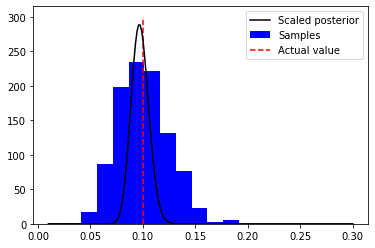

In [74]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=300, label="Actual value", color="red")
mod_true_prob = [x * 6 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

## Compute KDE

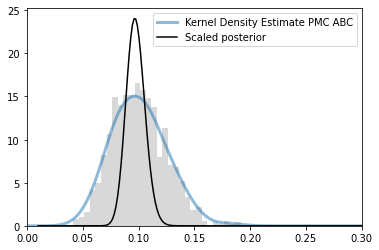

In [75]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)

t_samples = np.array([x for x in samples[:, 0]])

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

## Save data

In [76]:
pmc_fake_samples = samples[:, 0]
print(pmc_fake_samples)

[0.10107164 0.11288636 0.07236055 0.06431273 0.08698871 0.09234446
 0.10085307 0.10407369 0.09920432 0.1094827  0.11084937 0.10077363
 0.12650915 0.07421346 0.12835746 0.12604512 0.0829669  0.05528263
 0.08491751 0.06526128 0.08515942 0.08862808 0.11448484 0.12883448
 0.12531988 0.12213006 0.12214313 0.08636    0.10002606 0.08741427
 0.09294142 0.1234703  0.12740868 0.10601722 0.08188376 0.13647165
 0.10081018 0.09332732 0.09288564 0.09244748 0.08787108 0.07981085
 0.1228482  0.13194194 0.12266544 0.06907743 0.10921927 0.12722043
 0.1031403  0.07533078 0.10519619 0.10103704 0.10326417 0.12556203
 0.08902892 0.10823901 0.07744848 0.09103697 0.12899555 0.08875035
 0.11103464 0.12998517 0.13065204 0.08407433 0.06819056 0.13918387
 0.09958318 0.10736903 0.107777   0.08401324 0.08831588 0.09622122
 0.06062578 0.08821703 0.13387058 0.12057147 0.07658911 0.08482433
 0.08945238 0.1130154  0.09944088 0.09761936 0.07025113 0.09036566
 0.11236135 0.0770997  0.11423499 0.11514078 0.07391843 0.0753

In [96]:
some_str = "0.10107164 0.11288636 0.07236055 0.06431273 0.08698871 0.09234446 0.10085307 0.10407369 0.09920432 0.1094827  0.11084937 0.10077363 0.12650915 0.07421346 0.12835746 0.12604512 0.0829669  0.05528263 0.08491751 0.06526128 0.08515942 0.08862808 0.11448484 0.12883448 0.12531988 0.12213006 0.12214313 0.08636    0.10002606 0.08741427 0.09294142 0.1234703  0.12740868 0.10601722 0.08188376 0.13647165 0.10081018 0.09332732 0.09288564 0.09244748 0.08787108 0.07981085 0.1228482  0.13194194 0.12266544 0.06907743 0.10921927 0.12722043 0.1031403  0.07533078 0.10519619 0.10103704 0.10326417 0.12556203 0.08902892 0.10823901 0.07744848 0.09103697 0.12899555 0.08875035 0.11103464 0.12998517 0.13065204 0.08407433 0.06819056 0.13918387 0.09958318 0.10736903 0.107777   0.08401324 0.08831588 0.09622122 0.06062578 0.08821703 0.13387058 0.12057147 0.07658911 0.08482433 0.08945238 0.1130154  0.09944088 0.09761936 0.07025113 0.09036566 0.11236135 0.0770997  0.11423499 0.11514078 0.07391843 0.07533983 0.12860845 0.07833485 0.10605718 0.09651266 0.10006323 0.11957136 0.10386005 0.11669995 0.07043866 0.04878633 0.11107715 0.12155235 0.09655588 0.09784068 0.1027087  0.09043912 0.06659394 0.09624102 0.12603553 0.09203523 0.09200537 0.11588273 0.12185717 0.11296645 0.08136929 0.0761327  0.10552387 0.12481924 0.09188685 0.12882682 0.12469362 0.13606153 0.08413228 0.10230017 0.08130279 0.06822452 0.07892683 0.06907045 0.11001507 0.09467458 0.08311334 0.09228891 0.12597358 0.08529775 0.07124045 0.08628725 0.1177824  0.09374764 0.12009771 0.09574819 0.07361422 0.09884311 0.09340611 0.08979169 0.07957361 0.10206996 0.067949   0.10024156 0.10287682 0.09441672 0.05850034 0.1107656  0.11256103 0.08659436 0.09229684 0.14367127 0.10452422 0.08425524 0.1009939  0.09113433 0.09982439 0.10781561 0.09278451 0.07898855 0.09996423 0.07848182 0.07485275 0.1148371 0.07390596 0.12592899 0.08375935 0.10775379 0.07493868 0.07607023 0.10814686 0.11305891 0.10549328 0.10026648 0.04136495 0.09633866 0.09146294 0.08846857 0.13180152 0.07981336 0.08434389 0.07590211 0.11080932 0.08098274 0.1148748  0.11592965 0.05791727 0.09618919 0.08159079 0.10214787 0.11302875 0.14016822 0.1106638  0.11456086 0.11563016 0.08463518 0.10994015 0.12299494 0.14126564 0.09590019 0.10474516 0.09819285 0.08897519 0.12621635 0.13709063 0.08061794 0.09792597 0.12105481 0.11432964 0.11119551 0.10603489 0.08252522 0.10085272 0.10920767 0.07698715 0.07797121 0.11824301 0.12763998 0.11345353 0.09822766 0.11599863 0.06829449 0.13799708 0.08799988 0.07475234 0.06031195 0.08024008 0.13724378 0.12163656 0.10353671 0.10055393 0.09349145 0.07722205 0.10594447 0.12913132 0.07231344 0.10215538 0.08845607 0.140295   0.09964787 0.14104305 0.09142499 0.08890735 0.12377475 0.13092992 0.07968289 0.09358118 0.0833122 0.10810853 0.08644588 0.10468621 0.08925055 0.11096542 0.08741752 0.0664971  0.07852515 0.09071572 0.0953433  0.12499572 0.17168162 0.131834   0.13681555 0.10922364 0.11946182 0.10309141 0.09051111 0.09458112 0.08608369 0.07386552 0.10752928 0.06281046 0.05643502 0.07816486 0.11305109 0.10124422 0.08916564 0.07961432 0.08112216 0.11621409 0.09200909 0.10374156 0.06083022 0.09342576 0.07508457 0.11352664 0.14988937 0.10028083 0.12141319 0.08068402 0.08073149 0.08853545 0.12568497 0.06873815 0.12245412 0.07661011 0.08339784 0.10587476 0.11502454 0.0661196  0.10155093 0.08666768 0.13950778 0.09502479 0.10756607 0.10503042 0.09451617 0.09371922 0.11136834 0.09906918 0.13311782 0.08683611 0.08915803 0.11443809 0.13884272 0.09341607 0.11013834 0.11040811 0.06747106 0.13602241 0.05181112 0.07792473 0.08300326 0.05997722 0.13978626 0.08769453 0.11480476 0.05652504 0.11673941 0.11229112 0.09496015 0.07848762 0.07324265 0.08442534 0.08576754 0.09375097 0.06752884 0.11004407 0.08587328 0.181468   0.10111345 0.10864744 0.13186363 0.07158899 0.05898656 0.12918398 0.09657601 0.12740069 0.07392757 0.10368079 0.10023553 0.07735271 0.07136276 0.06877903 0.11671807 0.10918488 0.06930838 0.07598117 0.11212439 0.09231836 0.09618583 0.05714933 0.07389677 0.07156903 0.06200916 0.07410355 0.06741419 0.1141217  0.08989258 0.11200209 0.10058257 0.09270966 0.10683299 0.08587804 0.14152667 0.08763593 0.0883862  0.12523481 0.12412765 0.09437881 0.09049523 0.10807994 0.09855061 0.12762263 0.07602847 0.11313949 0.04511365 0.07965612 0.12217788 0.08876543 0.08377426 0.11279512 0.10997198 0.17798014 0.09335617 0.11207103 0.0821077  0.13590424 0.09567409 0.12404909 0.09345145 0.13629695 0.08563562 0.06320156 0.08684152 0.13465695 0.09301696 0.0976119  0.10864347 0.11536821 0.09965547 0.07558795 0.09727802 0.13843665 0.14950917 0.10165344 0.09740343 0.07775527 0.11433559 0.15283032 0.08368202 0.15505623 0.05685841 0.08154077 0.09878211 0.08441757 0.11116758 0.13577757 0.09223965 0.10576934 0.05617844 0.11110334 0.07586192 0.1439365  0.07845436 0.09919995 0.06189931 0.11618743 0.08133089 0.05584321 0.08492854 0.08371741 0.14375197 0.06735846 0.09206693 0.0941683  0.10048633 0.06723402 0.08254305 0.11155663 0.10274599 0.12293034 0.12810372 0.09103698 0.10145222 0.09053344 0.09701404 0.12415695 0.14597829 0.07766325 0.11216292 0.09105418 0.09395118 0.08304785 0.11858347 0.0747159  0.11781081 0.11558593 0.09816744 0.09780097 0.11429599 0.14019582 0.07918287 0.12936738 0.1321127  0.1248153  0.12481402 0.14046531 0.09718438 0.08017525 0.1175197  0.05743395 0.10117232 0.08325525 0.12040559 0.08913388 0.06849699 0.14138425 0.05849833 0.06305189 0.10719002 0.1111146  0.15146908 0.1414224  0.05855356 0.08985271 0.14590154 0.10945469 0.07389353 0.07120345 0.09966331 0.06529069 0.10283923 0.07480789 0.07305188 0.0787478  0.111187 0.10797649 0.06926441 0.09920357 0.11242909 0.08968635 0.15241917 0.09917966 0.11219284 0.11644128 0.05092336 0.13276874 0.05865782 0.08583326 0.12865103 0.04880489 0.13374698 0.10971055 0.09985519 0.07293839 0.09337885 0.12562272 0.10845888 0.11299028 0.09932707 0.0878003  0.08098692 0.09770588 0.10926011 0.08800005 0.09835808 0.10219719 0.13416888 0.1022178  0.0709489  0.10181255 0.06806219 0.10519874 0.07811791 0.08585912 0.08378991 0.09717339 0.07578579 0.13338946 0.11152256 0.07904739 0.06103037 0.15385263 0.11186191 0.09253862 0.1196239  0.06295461 0.11638664 0.10309779 0.11813132 0.11935953 0.09726155 0.09544883 0.07758406 0.10261676 0.12578079 0.14595373 0.11989451 0.08913497 0.04792779 0.08103436 0.09159459 0.09891201 0.13933003 0.12209806 0.08972497 0.08503054 0.0669301 0.09575081 0.07599491 0.11232753 0.07383624 0.12366252 0.07815063 0.07993713 0.14091433 0.08576189 0.14997615 0.04361199 0.12799807 0.0866879  0.07544548 0.08338112 0.10464391 0.12330145 0.0866319 0.10433657 0.12291042 0.17838596 0.11227144 0.10587126 0.10330235 0.0658673  0.09757249 0.11912656 0.11711227 0.10403121 0.08632931 0.13495981 0.11427021 0.05403689 0.08990084 0.10018488 0.06934042 0.10785193 0.12813572 0.14436735 0.13786796 0.06779557 0.05765792 0.1218423  0.08412729 0.14328113 0.13148155 0.1128997  0.15493593 0.11019368 0.09636703 0.13428181 0.07962241 0.13116317 0.1202877 0.05757675 0.06909399 0.1046974  0.096182   0.10707815 0.1567311 0.1296318  0.07414668 0.08650434 0.1355905  0.08668523 0.10937077 0.06633765 0.1020463  0.07787516 0.11436988 0.07569425 0.12412693 0.12446437 0.11706584 0.18727308 0.07205172 0.10978692 0.11224622 0.12966908 0.0809407  0.08815307 0.0781449  0.08132436 0.07361921 0.09268251 0.10340778 0.08785932 0.09270062 0.14234579 0.10022588 0.1475816  0.05937573 0.09134891 0.07984475 0.08966023 0.08793525 0.09165325 0.12472401 0.10630039 0.08551688 0.11247872 0.10388024 0.11397766 0.10887991 0.14527188 0.08821028 0.07761256 0.12048973 0.10833511 0.17097046 0.08336975 0.08619094 0.07175278 0.11457973 0.06711832 0.10613927 0.06866751 0.15819228 0.13056677 0.11583509 0.10880664 0.08822481 0.1177092  0.13142037 0.10938673 0.09937541 0.11171402 0.11683331 0.12413506 0.05617196 0.06570405 0.07970382 0.07532894 0.08833429 0.11080205 0.13279495 0.11629975 0.08829544 0.08826773 0.10206194 0.0791747  0.10197964 0.06324203 0.10253829 0.07698351 0.13244144 0.10988067 0.11445515 0.09022176 0.08613015 0.09263258 0.11387093 0.09839953 0.07783548 0.12908204 0.09367705 0.10986366 0.08895499 0.08117552 0.112639   0.14378379 0.08740917 0.08547889 0.1059193  0.14407213 0.10510933 0.07139891 0.09806337 0.15914679 0.10647005 0.108118   0.06307621 0.08561581 0.14983139 0.09183936 0.10491501 0.14905875 0.12549386 0.05794495 0.12070856 0.11913145 0.09829912 0.07825799 0.10317638 0.07602778 0.06136495 0.10100044 0.12401652 0.10933119 0.12310329 0.11176206 0.14041984 0.09348913 0.05034218 0.16901905 0.12146588 0.07955147 0.06819015 0.15073687 0.1021513  0.13263751 0.11077055 0.10672919 0.04493885 0.14249331 0.12057409 0.09980657 0.07449007 0.0657397  0.09766525 0.10291774 0.08344212 0.12797149 0.08661075 0.0869239  0.11026014 0.09486935 0.08611214 0.12591467 0.11531153 0.12587743 0.11421303 0.05413226 0.0849046  0.06372337 0.10289606 0.10549032 0.09192731 0.08812747 0.09735225 0.14381041 0.08490153 0.10749206 0.12324667 0.12743638 0.12419836 0.10423883 0.08420139 0.07815979 0.09718813 0.07178678 0.10019846 0.07199151 0.11464618 0.11027434 0.09249132 0.11505178 0.1139097  0.07643254 0.07396075 0.10548428 0.09233109 0.10534377 0.11060864 0.10514528 0.09941369 0.12789578 0.12961397 0.09133683 0.12609776 0.08479513 0.0772449  0.12105859 0.09590293 0.11072894 0.08850262 0.06370476 0.06733887 0.11814301 0.07582365 0.15140136 0.13531421 0.10152903 0.10032618 0.09506364 0.11764524 0.13915999 0.15375188 0.13407258 0.08267795 0.11897636 0.12333493 0.08975668 0.1027689  0.09138431 0.11447658 0.07806521 0.09674976 0.10988163 0.07971043 0.11313536 0.08546212 0.08004712 0.093201 0.07761238 0.07559411 0.07764086 0.09530671 0.11648574 0.10484983 0.13539739 0.08958797 0.06883189 0.10146983 0.10813967 0.12766175 0.09592791 0.08069914 0.10495591 0.09543617 0.08376941 0.0896618 0.10025718 0.14052762 0.13336315 0.14703032 0.06871318 0.13991429 0.13121787 0.09601053 0.0817438  0.13295571 0.14544741 0.18532856 0.08497503 0.11106161 0.09863889 0.14274529 0.12218177 0.09330064 0.10138953 0.0692648  0.0782703  0.10387999 0.10419954 0.12143248 0.10929778 0.15560256 0.07389552 0.06628423 0.10247229 0.06707759 0.14006421 0.0743651  0.11872454 0.08273067 0.08255833 0.08631184 0.10300354 0.07857573 0.07472923 0.09300801 0.09980493 0.0802222 0.08305979 0.06223431 0.09021846 0.13634747 0.10124459 0.07988874 0.13393364 0.07642275 0.08226343 0.12879181 0.08487538 0.11788071 0.06900526 0.06433575 0.06936503 0.1237855  0.09905516 0.11397161 0.1198066  0.07818896 0.06319307 0.10994488 0.07740067 0.10629648 0.13173057 0.08399633 0.09158506 0.06478063 0.07418489 0.09850032 0.15377245 0.06177347 0.12112111 0.1164519  0.07750784 0.12296444 0.08669521 0.10724664 0.10515108 0.10089665 0.08448689 0.09607234 0.10039822 0.06661943 0.06869589 0.12257893 0.13509423 0.10250175 0.05171772 0.10889768 0.15576969 0.10194971 0.12850148 0.12626002 0.06344212 0.10853715 0.10228232 0.10304145 0.10065003 0.19148505 0.13227541 0.1112464  0.15489108 0.09662284"

In [97]:
lmao = [ch for ch in some_str]


saved = list(filter(None, some_str.split(' ')))

result = [float(s) for s in saved]

pmc_fake_samples = result

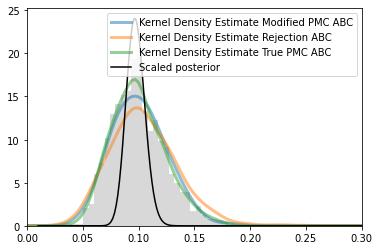

In [94]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)

t_samples = pmc_fake_samples
p_samples = np.array([x for z in rej_abc_samples for y in z for x in y])
r_samples = true_pmc_samples

# print(p_samples)

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(p_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(r_samples, x_grid, bandwidth=0.007),
            label='Kernel Density Estimate True PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

# Adaptive PMC ABC

In [33]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

# set threshold
abc.sampler().set_N_l(1000)

# set p_acc_min
abc.sampler().set_p_acc_min(0.05)

# set target number of samples
abc.set_n_samples(1400)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.13364221]
resulting var=[[0.0098423]]
epsilon=4.5166359162544865
w_mean=[0.12054445]
resulting var=[[0.00722191]]
epsilon=3.6945906403822333
w_mean=[0.11462157]
resulting var=[[0.00508299]]
epsilon=3.170173496829472
w_mean=[0.11322349]
resulting var=[[0.00429988]]
epsilon=2.6832815729997477
w_mean=[0.11016327]
resulting var=[[0.00363032]]
epsilon=2.3558437978779496
w_mean=[0.10880012]
resulting var=[[0.00292873]]
epsilon=2.1447610589527217
w_mean=[0.10981363]
resulting var=[[0.00268821]]
epsilon=1.9621416870348585
w_mean=[0.10942333]
resulting var=[[0.0024786]]
epsilon=1.8165902124584952
w_mean=[0.10865194]
resulting var=[[0.00220273]]
epsilon=1.7320508075688772
w_mean=[0.10952655]
resulting var=[[0.00230237]]
epsilon=1.6583123951777
w_mean=[0.10891767]
resulting var=[[0.00217723]]
epsilon=1.5968719422671314
w_mean=[0.10842868]
resulting var=[[0.00211797]]
epsilon=1.5491933384829668
w_mean=[0.10878124]
resulting va

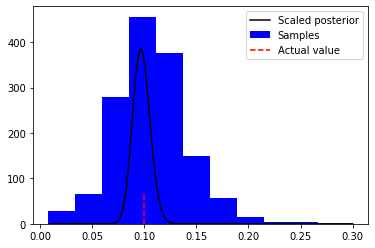

In [36]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=70, label="Actual value", color="red")
mod_true_prob = [x * 8 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

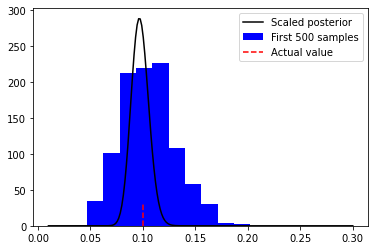

In [37]:
plt.hist(samples[:1000,0], color="blue", label="First 500 samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=30, label="Actual value", color="red")
mod_true_prob = [x * 6 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

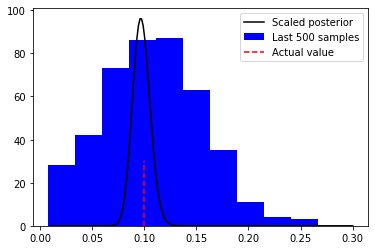

In [41]:
plt.hist(samples[1000:,0], color="blue", label="Last 500 samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=30, label="Actual value", color="red")
mod_true_prob = [x * 2 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

## Compute KDE

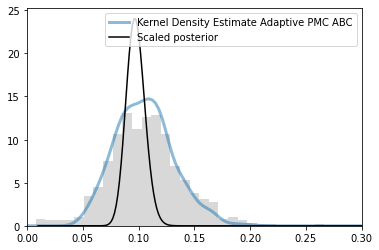

In [38]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)

t_samples = np.array([x for x in samples[:1000, 0]])

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.007),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

## Save data

In [48]:
adaptive_pmc_samples = samples[:, 0]
print(adaptive_pmc_samples.tolist())


[0.1261103406262467, 0.1606812520492969, 0.10990272050250612, 0.10698728433682766, 0.10526157039049214, 0.06439072391998608, 0.08568112017327069, 0.10714048010986822, 0.15083362575276643, 0.06564623589881181, 0.11423777511486241, 0.07784412132128313, 0.13100096391810898, 0.11340072259456664, 0.061829290551175094, 0.09797649036517184, 0.12821324082538635, 0.05947577242572779, 0.0947676434054726, 0.07306522149004042, 0.08660650549920669, 0.0684234579164836, 0.07830492876107231, 0.13212367531841085, 0.11421515148324468, 0.12593068804318217, 0.07295474294181854, 0.13696197403932295, 0.0763879530691775, 0.11350100304025701, 0.08300202490513792, 0.111622610667662, 0.053506285487794444, 0.08364729497924922, 0.07876706287073268, 0.0833722571569871, 0.08340309688242993, 0.1404935733766383, 0.055610665462237814, 0.10348360170484916, 0.09798590066763053, 0.09712900527389444, 0.1337847878336416, 0.13577043755134297, 0.1671768123690776, 0.06752126474584336, 0.11555579120344087, 0.10690579149311158,

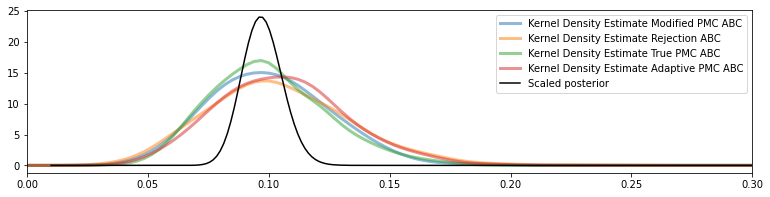

In [107]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(13, 3))

t_samples = np.array(pmc_fake_samples)
p_samples = np.array(rej_abc_samples)
r_samples = np.array(true_pmc_samples)
w_samples = np.array(adaptive_pmc_samples[:1000])

# print(p_samples)

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(p_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(r_samples, x_grid, bandwidth=0.007),
            label='Kernel Density Estimate True PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(w_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
# ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')